# Imports

In [1]:
import torch
import seaborn as sns
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn

# Vamos entender cada parte do "Masked Multi-Head Attention"

## Motivação

O embeddings da camada anterior são estáticos, ou seja, seu valor independe do contexto no qual o token está inserido.

Idealmente, seria interessante alterar o valor do embedding de uma palavra com base nas palavras adjacentes.

### Exemplo:
"Joana não atravessou a estrada porque ela"

<div style="text-align: center;">
    <img src="figures/attention.png" alt="Atenção" width="50%"/>
</div>

### Contextualizando embeddings do token "ela"

In [2]:
def plot_heatmap(attention_weights, x_labels, y_labels, title="Mapa de Atenção", xlabel="Tokens Alvo", ylabel="Tokens de Origem"):
    if attention_weights.is_cuda:
        attention_weights = attention_weights.cpu()
    attention_weights_np = attention_weights.detach().numpy()

    plt.figure(figsize=(7, 5))
    ax = sns.heatmap(
        attention_weights_np,
        xticklabels=x_labels,
        yticklabels=y_labels,
        annot=True,
        fmt=".2f",
        cmap='viridis',
        cbar=True,
        vmin=0,
        vmax=1
    )

    ax.set_title(title, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlabel(xlabel, fontsize=12)

    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    plt.tight_layout()
    plt.show()

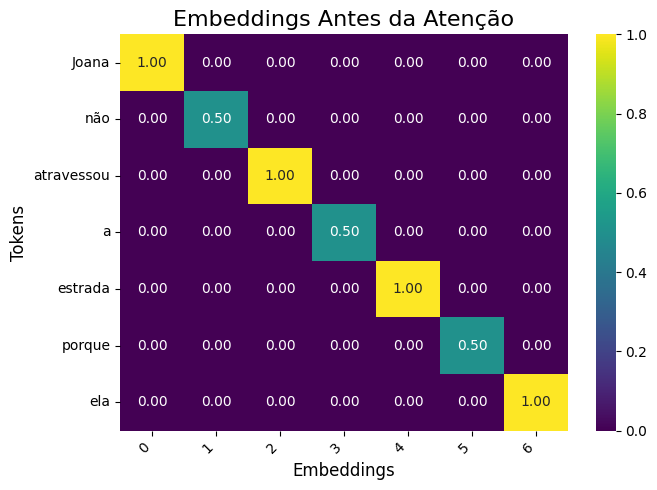

In [3]:
X = torch.tensor([[1., 0., 0., 0., 0., 0., 0.],    # "Joana"
                  [0., 0.5, 0., 0., 0., 0., 0.],    # "não"
                  [0., 0., 1., 0., 0., 0., 0.],    # "atravessou"
                  [0., 0., 0., 0.5, 0., 0., 0.],    # "a"
                  [0., 0., 0., 0., 1., 0., 0.],    # "estrada"
                  [0., 0., 0., 0., 0., 0.5, 0.],    # "porque"
                  [0., 0., 0., 0., 0., 0., 1.]],    # "ela"
).float()

tokens = ["Joana", "não", "atravessou", "a", "estrada", "porque", "ela"]
plot_heatmap(
    X,
    x_labels=list(range(X.shape[1])),
    y_labels=tokens,
    title="Embeddings Antes da Atenção",
    xlabel="Embeddings",
    ylabel="Tokens"
)

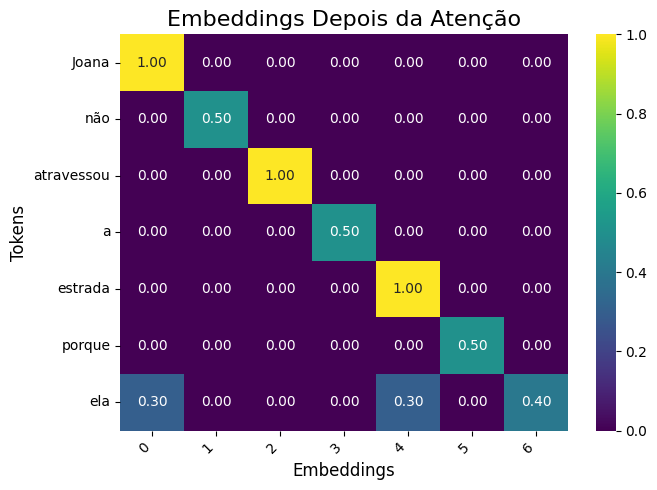

In [4]:
attention = torch.tensor([
                [1., 0., 0., 0., 0., 0., 0.], 
                [0., 1., 0., 0., 0., 0., 0.],
                [0., 0., 1., 0., 0., 0., 0.],
                [0., 0., 0., 1., 0., 0., 0.],
                [0., 0., 0., 0., 1., 0., 0.], 
                [0., 0., 0., 0., 0., 1., 0.],
                [0.3, 0., 0., 0., 0.3, 0., 0.4],    # mapa de atenção para a palavra "ela"
]).float()

tokens = ["Joana", "não", "atravessou", "a", "estrada", "porque", "ela"]
plot_heatmap(
    attention.matmul(X), # X após a atenção
    x_labels=list(range(X.shape[1])),
    y_labels=tokens,
    title="Embeddings Depois da Atenção",
    xlabel="Embeddings",
    ylabel="Tokens"
)

## Matriz de atenção

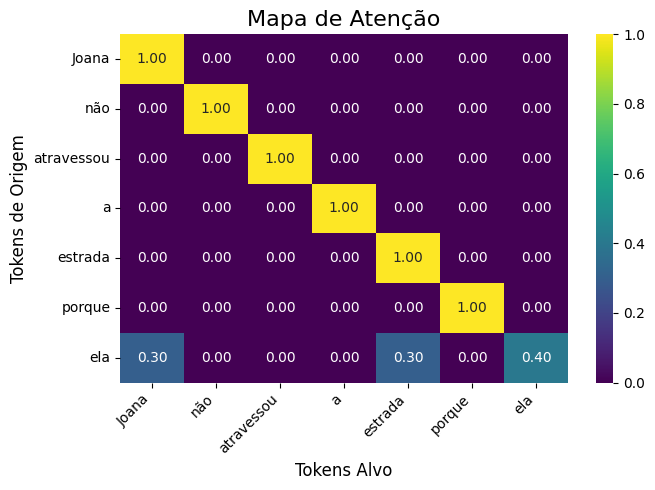

In [5]:
attention = torch.tensor([
                [1., 0., 0., 0., 0., 0., 0.], 
                [0., 1., 0., 0., 0., 0., 0.],
                [0., 0., 1., 0., 0., 0., 0.],
                [0., 0., 0., 1., 0., 0., 0.],
                [0., 0., 0., 0., 1., 0., 0.], 
                [0., 0., 0., 0., 0., 1., 0.],
                [0.3, 0., 0., 0., 0.3, 0., 0.4],    # mapa de atenção para a palavra "ela"
]).float()

tokens = ["Joana", "não", "atravessou", "a", "estrada", "porque", "ela"]
plot_heatmap(
    attention,
    x_labels=tokens,
    y_labels=tokens,
    title="Mapa de Atenção",
)

# Como gerar um mapa de atenção?

### Primeira parte "Attention": Scaled Dot-Product

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

### Query, Keys e Values: uma intuição

### Entendendo melhor a fórmula: $QK^T$ é uma medida de similaridade entre a query e keys.

A multiplicação matricial $QK^T$ pode ser decomposta em vários produtos escalares:

$$
\vec{q_i} \cdot \vec{k_i} = \|\vec{q_i}\| \|\vec{k_i}\| \cos(\theta)
$$

In [6]:
import matplotlib.pyplot as plt

def plot_tensors_2d(q_i, k_i, dot_product):
  q_np = q_i.numpy()
  k_np = k_i.numpy()

  fig = plt.figure(figsize=(6, 2.5))
  ax = fig.add_subplot(111)

  ax.quiver(0, 0, q_np[0], q_np[1] ,
            angles='xy', scale_units='xy', scale=1, 
            color='blue', label='q_i', linewidth=3)

  ax.quiver(0, 0, k_np[0], k_np[1],
            angles='xy', scale_units='xy', scale=1, 
            color='red', label='k_i', linewidth=3)

  ax.text(0.05, 0.95, f'Produto escalar: {dot_product.item():.4f}',
          transform=ax.transAxes, fontsize=12,
          verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

  ax.set_xlim([-1.5, 1.5])
  ax.set_ylim([-1.5, 1.5])

  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.legend()

  ax.grid(True)

  plt.show()

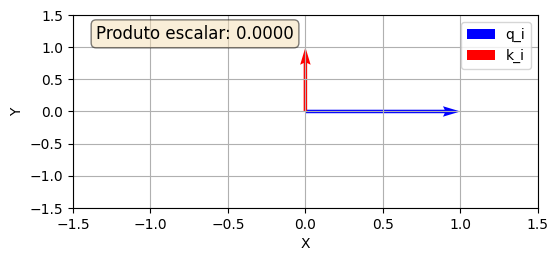

In [7]:
q_i = torch.tensor([1, 0]).float()
k_i = torch.tensor([0, 1]).float()
plot_tensors_2d(q_i, k_i, q_i @ k_i)

### Função softmax

$$S(\mathbf{z})_i = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}$$

In [8]:
qK = torch.tensor([1.0, 2.0, -1.0])
softmax_qK = F.softmax(qK, dim=0)
print(f"Scores antes do Softmax: {qK.numpy()}")
print(f"Porcentagens de atenção (após Softmax): {[f'{p:.5f}' for p in softmax_qK]}\n")

Scores antes do Softmax: [ 1.  2. -1.]
Porcentagens de atenção (após Softmax): ['0.25950', '0.70538', '0.03512']



### Saturação do softmax

In [9]:
qK = torch.tensor([5.0, 10.0, -5.0])
softmax_qK = F.softmax(qK, dim=0)
print(f"Scores antes do Softmax: {qK.numpy()}")
print(f"Porcentagens de atenção (após Softmax): {[f'{p:.5f}' for p in softmax_qK]}\n")

Scores antes do Softmax: [ 5. 10. -5.]
Porcentagens de atenção (após Softmax): ['0.00669', '0.99331', '0.00000']



Dividimos o vetor de simularidade $QK^T$ por $\sqrt{d_k}$ para evitar saturação da função softmax.


## Implementação da função de atenção

In [10]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.fc_q = nn.Linear(d_model, d_model)
        self.fc_k = nn.Linear(d_model, d_model)
        self.fc_v = nn.Linear(d_model, d_model)
        self.scale = torch.sqrt(torch.FloatTensor([d_model]))

    def forward(self, x):
        Q, K, V = self.fc_q(x), self.fc_k(x), self.fc_v(x)
        qK = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        attention = torch.softmax(qK, dim=-1)
        return attention, torch.matmul(attention, V)

In [11]:
BATCH_SIZE = 1         # "Olá Mundo!
SEQUENCE_LENGTH = 3    # 3 palavras
EMBEDDING_DIM = 3      # dimensão do embedding

att_layer = ScaledDotProductAttention(d_model=EMBEDDING_DIM)

X = torch.randn(BATCH_SIZE, SEQUENCE_LENGTH, EMBEDDING_DIM)
attention_map, scaled_values = att_layer(X)

sentence_tokens = ['Hello', 'World', '!']

print(f'Mapa de Atenção:\n{attention_map.detach().numpy()}\n')
print(f'Valores escalados:\n{scaled_values.detach().numpy()}\n')

Mapa de Atenção:
[[[0.30903968 0.32262123 0.36833912]
  [0.3710073  0.30555502 0.3234377 ]
  [0.5222082  0.2134263  0.26436546]]]

Valores escalados:
[[[-0.31258544  0.46707237 -0.09950101]
  [-0.2838205   0.35431516 -0.01491712]
  [-0.18085429  0.09276927  0.16260065]]]



## "Masked": evitando valores futuros

In [12]:
mask = torch.tril(torch.ones(EMBEDDING_DIM, EMBEDDING_DIM))
mask

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

In [13]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.fc_q = nn.Linear(d_model, d_model)
        self.fc_k = nn.Linear(d_model, d_model)
        self.fc_v = nn.Linear(d_model, d_model)
        self.scale = torch.sqrt(torch.FloatTensor([d_model]))

    def forward(self, x, mask=None):
        Q, K, V = self.fc_q(x), self.fc_k(x), self.fc_v(x)
        qK = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        if mask is not None:
            # Substituimos valores iguais a zero na máscara por um número negativo muito grande
            qK = qK.masked_fill(mask == 0, -1e10)
        # Desta forma, a função softmax se encarrega zerar a atenção nos tokens futuros
        attention = torch.softmax(qK, dim=-1) # e^-1000000000 ~ 0
        return attention, torch.matmul(attention, V)

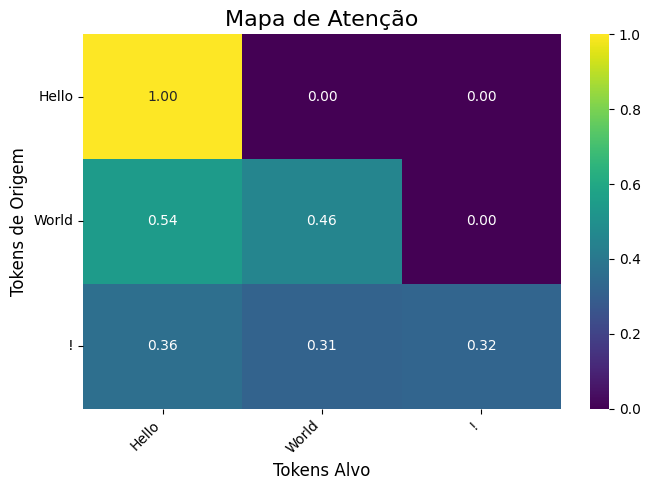

In [14]:
att_layer = ScaledDotProductAttention(d_model=EMBEDDING_DIM)

X = torch.randn(BATCH_SIZE, SEQUENCE_LENGTH, EMBEDDING_DIM)
attention_map, scaled_values = att_layer(X, mask=mask)

tokens = ['Hello', 'World', '!']
plot_heatmap(
    attention_map[0], 
    x_labels=tokens,
    y_labels=tokens,
)

## "Multi-Head"

<div style="text-align: center;">
    <img src="figures/mha.png" alt="Multi-Head Attention" width="25%"/>
</div>

In [15]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_model, dim_head):
        super().__init__()
        self.dim_heads = dim_head
        self.fc_q = nn.Linear(d_model, dim_head)
        self.fc_k = nn.Linear(d_model, dim_head)
        self.fc_v = nn.Linear(d_model, dim_head)
        self.scale = torch.sqrt(torch.FloatTensor([dim_head]))

    def forward(self, x, mask=None):
        Q, K, V = self.fc_q(x), self.fc_k(x), self.fc_v(x)
        qK = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        if mask is not None:
            # Substituimos valores iguais a zero na máscara por um número negativo muito grande
            qK = qK.masked_fill(mask == 0, -1e10)
        # Desta forma, a função softmax se encarrega zerar a atenção nos tokens futuros
        attention = torch.softmax(qK, dim=-1) # e^-1000000000 ~ 0
        return attention, torch.matmul(attention, V)


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()

        assert d_model % n_heads == 0

        self.heads = nn.ModuleList([
            ScaledDotProductAttention(d_model, d_model // n_heads)
            for _ in range(n_heads)
        ])

        self.linear = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        head_outputs = [head(x, mask) for head in self.heads]
        attention_maps = [out[0] for out in head_outputs]
        scaled_values = [out[1] for out in head_outputs]

        concatenated = torch.cat(scaled_values, dim=-1)
        return attention_maps, self.linear(concatenated)

In [16]:
mha = MultiHeadAttention(d_model=EMBEDDING_DIM, n_heads=3)
attention_maps, values = mha(X, mask=mask)
attention_maps

[tensor([[[1.0000, 0.0000, 0.0000],
          [0.5581, 0.4419, 0.0000],
          [0.3293, 0.3419, 0.3287]]], grad_fn=<SoftmaxBackward0>),
 tensor([[[1.0000, 0.0000, 0.0000],
          [0.5442, 0.4558, 0.0000],
          [0.3313, 0.3184, 0.3503]]], grad_fn=<SoftmaxBackward0>),
 tensor([[[1.0000, 0.0000, 0.0000],
          [0.4633, 0.5367, 0.0000],
          [0.4364, 0.2074, 0.3562]]], grad_fn=<SoftmaxBackward0>)]

In [17]:
values

tensor([[[-0.4996,  0.9472,  0.3796],
         [-0.2446,  0.4228, -0.2074],
         [-0.2968,  0.2992, -0.2279]]], grad_fn=<ViewBackward0>)